In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
# Define company name and date ranges

In [4]:
COMPANY_IDENTIFIER = ['TJR']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C9-0000105-LIC'], dtype=object)

In [9]:
def check_company_license_download(license_numbers: List[str],download_summary_records: List[Dict[str,str]]) -> Dict[str,str]:
    license_number_to_download_summary_records = {}

    for license_number in license_numbers:
        license_number_to_download_summary_records[license_number] = list(filter(
            lambda download_summary_record: download_summary_record['license_number'] == license_number,
            download_summary_records
        ))

    bad_count = 0
    bad_history = defaultdict(list)
    for license_number, download_summary_records in license_number_to_download_summary_records.items():
        print(f'Verifying download summaries for license {license_number}...')
        print(f'Earliest download summary: {download_summary_records[-1]["date"]}')
        print(f'Latest download summary: {download_summary_records[0]["date"]}')
        for download_summary_record in download_summary_records:
            if download_summary_record['status'] != 'completed':
                bad_count += 1
                print(f'Found bad download summary for license {license_number} on date {download_summary_record["date"]}') 
                bad_history[license_number].append(download_summary_record['date'])            
        
        print('')
    if bad_count > 0:
        print(f'[FAILURE] Found a total of {bad_count} bad download summaries')
    else:
        print(f'[SUCCESS] All download summaries look good!')
    return bad_history



In [10]:
bad_download_history = check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C9-0000105-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-03-08

[SUCCESS] All download summaries look good!


In [11]:
bad_download_history

defaultdict(list, {})

## Choose license numbers

In [12]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C9-0000105-LIC']

In [ ]:
#for BUD only
#license_numbers = ['C9-0000464-LIC',
# 'C9-0000467-LIC',
# 'C9-0000399-LIC']

In [ ]:
# run this if only has 1 license, or only want 1 license
#license_numbers = [license_numbers[0]]
#license_numbers

# License check

In [13]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]


In [14]:
retial_license_check_df

,license_number,license_category,is_current,license_status,license_check
0,C9-0000105-LIC,Retailer,True,Active,YES


## Pull data

In [15]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [16]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C9-0000105-LIC'], dtype=object)

In [17]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C9-0000105-LIC'], dtype=object)

In [18]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C9-0000105-LIC'], dtype=object)

## Unknown transfer packages

In [19]:
def check_unknown_transfer_packages(unknown_transfer_df: pd.DataFrame) -> int:
    unknown_package_count = unknown_transfer_df.shape[0]
    if unknown_package_count > 0:
        print(f'[FAILURE] Found a total of {unknown_package_count} unknown transfer packages')
    else:
        print(f'[SUCCESS] No unknown transfer packages!')
    return unknown_package_count

In [20]:
unknown_package_count = check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [21]:
def check_receiver_wholesale_price_coverage(incoming_transfer_df: pd.DataFrame) -> float:
    rwp_exists_count = incoming_transfer_df[incoming_transfer_df['receiver_wholesale_price'].notnull()].shape[0]
    total_count = incoming_transfer_df.shape[0]
    rwp_coverage = round(rwp_exists_count / total_count, 2) * 100
    print(f'{rwp_coverage}% of incoming transfer packages have receiver wholesale price')
    return rwp_coverage

In [22]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(180129, 32)

In [23]:
company_incoming_transfer_packages_dataframe.shape

(182599, 32)

In [24]:
rwp_coverage = check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


99.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [25]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [26]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [27]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C9-0000105-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [28]:
def check_incoming_transfer_package_coverage(incoming_transfer_df: pd.DataFrame,sales_df: pd.DataFrame) -> Tuple[List,pd.DataFrame]:
    package_transfer_sales_merged = pd.merge(sales_df,incoming_transfer_df,left_on='tx_package_id', right_on='package_id', how='left')
    package_transfer_sales_merged_missed = package_transfer_sales_merged[package_transfer_sales_merged['package_id'].isnull()]
    count_trxn_missed = package_transfer_sales_merged_missed.shape[0]
    count_total_trxn = sales_df.shape[0]
    missed_ratio = count_trxn_missed/ count_total_trxn
    print(f'# transactions missing incoming transfer package: {count_trxn_missed} ({count_trxn_missed / count_total_trxn * 100}%)')
    print(f'# transactions total: {count_total_trxn}')
    return missed_ratio,package_transfer_sales_merged_missed

In [29]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 98602 (24.05220148798634%)
# transactions total: 409950


In [30]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2020-03    203
2020-04    519
2020-05    453
2020-06     65
2020-07    325
2020-08    408
2020-09    563
2020-10    467
2020-11    572
2020-12    188
2021-01    177
2021-02    163
2021-03    115
dtype: int64

## Receipts missing metrc_sales_transactions

In [31]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [32]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 33305


In [33]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

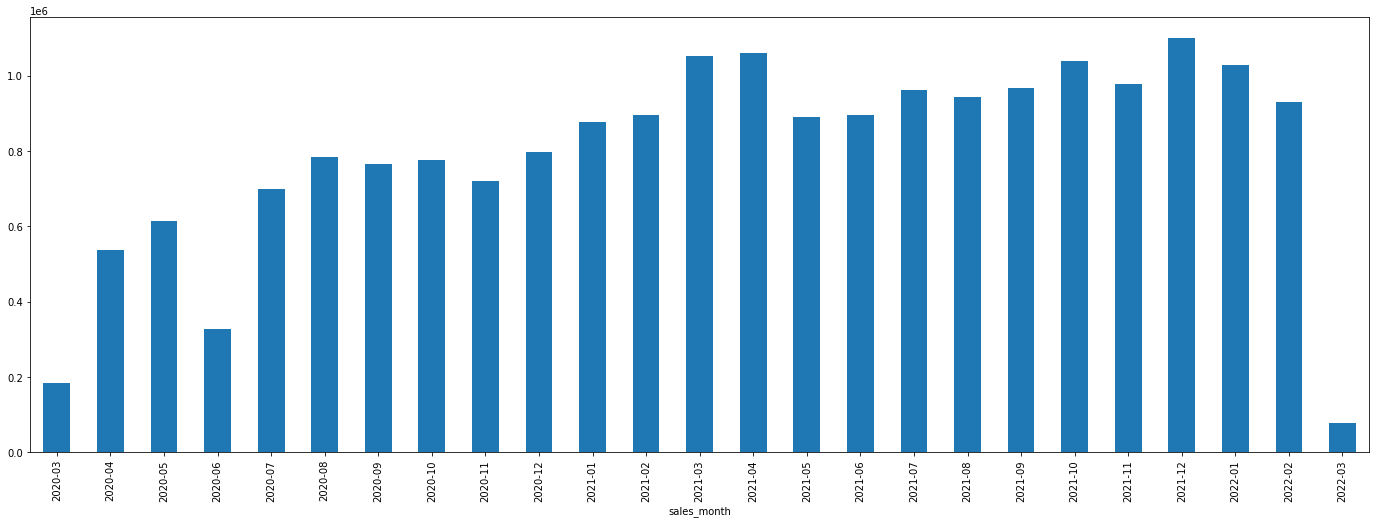

In [34]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# For Embarc only

In [ ]:
if COMPANY_IDENTIFIER == ['EMA','EMM','EMT']:
    #incoming transfer
    company_incoming_transfer_packages_dataframe_ema = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_incoming_transfer_packages_dataframe_emm = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_incoming_transfer_packages_dataframe_emt = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    #sales & receipt
    deduped_sales_receipts_with_transactions_dataframe_ema = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000774-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emm = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000786-LIC']
    deduped_sales_receipts_with_transactions_dataframe_emt = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C10-0000695-LIC']
    #inventory
    company_inventory_packages_dataframe_ema = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000774-LIC']
    company_inventory_packages_dataframe_emm = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000786-LIC']
    company_inventory_packages_dataframe_emt = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C10-0000695-LIC']
    

# For BUD only

In [ ]:
if COMPANY_IDENTIFIER == ['BUD']:
    #incoming transfer
    company_incoming_transfer_packages_dataframe_sac = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000399-LIC']
    company_incoming_transfer_packages_dataframe_fresno = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000467-LIC']
    company_incoming_transfer_packages_dataframe_la = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'] == 'C9-0000464-LIC']
    #sales & receipt
    deduped_sales_receipts_with_transactions_dataframe_sac = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000399-LIC']
    deduped_sales_receipts_with_transactions_dataframe_fresno = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000467-LIC']
    deduped_sales_receipts_with_transactions_dataframe_la = deduped_sales_receipts_with_transactions_dataframe[deduped_sales_receipts_with_transactions_dataframe['license_number'] == 'C9-0000464-LIC']

    
    #inventory
    company_inventory_packages_dataframe_sac = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000399-LIC']
    company_inventory_packages_dataframe_fresno = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000467-LIC']
    company_inventory_packages_dataframe_la = company_inventory_packages_dataframe[company_inventory_packages_dataframe['license_number'] == 'C9-0000464-LIC']

    

# Vendor churn

In [35]:
WINDOW = 4
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-03-01'
VC_MONTH_LIST = ['2021-11-01','2021-12-01','2022-01-01','2022-02-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [36]:
def calculate_vendor_churn(incoming_transfer_df,license_list,vc_windown,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(vc_windown).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix
    


## embarc only

In [ ]:
churn_ema,vc_matrix_ema = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_ema,['C10-0000774-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emm,vc_matrix_emm = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emm,['C10-0000786-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_emt,vc_matrix_emt = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_emt,['C10-0000695-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)



## BUD only

In [ ]:
churn_sac,vc_matrix_sac = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_sac,['C9-0000399-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_fresno,vc_matrix_fresno = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_fresno,['C9-0000467-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
churn_la,vc_matrix_la = calculate_vendor_churn(company_incoming_transfer_packages_dataframe_la,['C9-0000464-LIC'],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)




In [ ]:
# ax = churn_la['%_inactive'].plot(marker = 'o',figsize = (12,8))
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
# ax = plt.title('Rolling 4m vendor churn')

## Others

In [37]:
license_numbers

['C9-0000105-LIC']

In [50]:
# TJR
#test = company_incoming_transfer_packages_dataframe[(company_incoming_transfer_packages_dataframe['shipper_facility_name'] != 'PRUSSIAN STICKS LLC')&(company_incoming_transfer_packages_dataframe['shipper_facility_name'] != 'PRUSSIAN STICKS, LLC')]


In [51]:
churn,vc_matrix = calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)

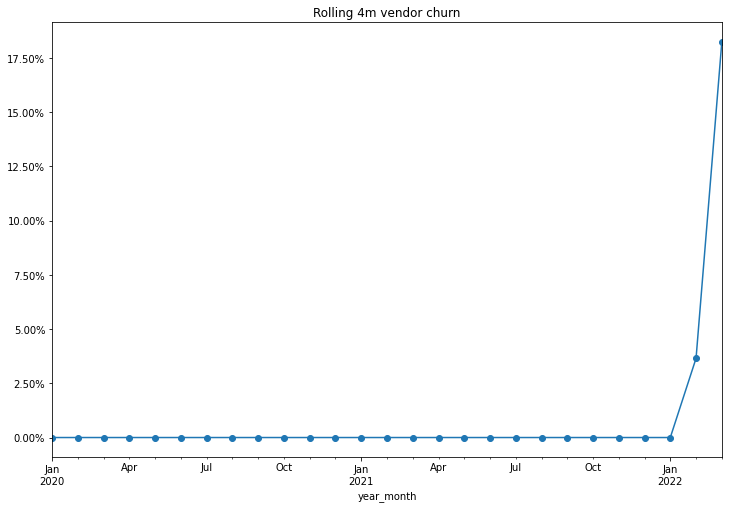

In [54]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')

# Receiver wholesale price outlier check

In [42]:
def check_per_unit_incoming(incoming_transfer_df: pd.DataFrame) -> Tuple[pd.DataFrame,pd.DataFrame]:
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    # by package ID
    per_unit_incoming_package_sort = incoming_transfer_df[['package_id','per_unit_incoming']].groupby(['package_id']).mean().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_package_top5 = per_unit_incoming_package_sort[0:5]
    print('printing per unit incoming by package ID summary ...')
    print(f'max per unit incoming: {per_unit_incoming_package_sort["per_unit_incoming"][0]}' + f' from package ID: {per_unit_incoming_package_sort["package_id"][0]}')
    print(f'min per unit incoming: {per_unit_incoming_package_sort.dropna()["per_unit_incoming"][-1:].values[0]}' + f' from package ID: {per_unit_incoming_package_sort.dropna()["package_id"][-1:].values[0]}')
    #print(per_unit_incoming_package_top5)
    print('')
    #by product name
    per_unit_incoming_product_sort = incoming_transfer_df[['product_name','per_unit_incoming']].groupby(['product_name']).max().sort_values(by = 'per_unit_incoming',ascending = False).reset_index()
    per_unit_incoming_product_top5 = per_unit_incoming_product_sort[0:5]
    return per_unit_incoming_package_sort,per_unit_incoming_product_sort


In [43]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 344.85 from package ID: 11035975
min per unit incoming: 0.001 from package ID: 22153001



In [44]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(5)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,11035975,344.85
1,17953756,224.20
2,22064663,208.05
3,17179274,208.05
4,15092094,208.05


In [45]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
182460,19663043,0.001667
182461,19663057,0.001667
182462,19663059,0.001667
182463,19663019,0.001667
182464,22153001,0.001000


In [ ]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

# COGS analysis

In [46]:
def cogs_analysis(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage']]
    
    return df_summary_simp,df_cogs_average_product




In [47]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

## For Others

In [48]:
df_summary_simp,df_cogs_average_product = cogs_analysis(df_in,df_sales,'monthly')
#tax treatment
df_summary_simp['revenue_after_tax'] = df_summary_simp['revenue'] * 1.15
df_summary_simp['cogs_after_tax'] = df_summary_simp['cogs'] * 1.27
df_summary_simp['margin_$_after_tax'] = df_summary_simp['revenue_after_tax'] - df_summary_simp['cogs_after_tax']
df_summary_simp['margin_%_after_tax'] = df_summary_simp['margin_$_after_tax'] / df_summary_simp['revenue_after_tax']
# past quarter pre tax
df_summary_simp['gm_past_quarter'] = df_summary_simp[['margin_%']].rolling(3).mean().values
df_summary_simp['gm_past_2quarters'] = df_summary_simp[['margin_%']].rolling(6).mean().values
df_summary_simp['gm_past_3quarters'] = df_summary_simp[['margin_%']].rolling(9).mean().values
df_summary_simp['sum_cogs_past_3months'] = df_summary_simp[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp['gm_past_quarter_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp['gm_past_2quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp['gm_past_3quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()
df_summary_simp.index = df_summary_simp.date 


In [49]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,revenue_change
date,,,,,,,,,,,,,,,,,,,,,
2020-12,2020-12,797602.01,7.409056e+05,56696.415387,0.071084,14075.0,3491.0,10584,0.952494,9.172423e+05,9.409501e+05,-23707.793658,-0.025847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01,2021-01,875627.79,9.590484e+05,-83420.607693,-0.095269,17484.0,1368.0,16116,0.957922,1.006972e+06,1.217991e+06,-211019.506570,-0.209558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097825
2021-02,2021-02,896330.73,9.778202e+05,-81489.443510,-0.090914,17401.0,993.0,16408,0.965381,1.030780e+06,1.241832e+06,-211051.280857,-0.204749,-0.038367,NaN,NaN,2.677774e+06,-0.146718,NaN,NaN,0.023644
2021-03,2021-03,1051708.92,1.043087e+06,8622.203515,0.008198,21148.0,598.0,20550,0.965354,1.209465e+06,1.324720e+06,-115254.871936,-0.095294,-0.059329,NaN,NaN,2.979955e+06,-0.169867,NaN,NaN,0.173349
2021-04,2021-04,1060004.60,1.007504e+06,52501.089015,0.049529,19916.0,0.0,19916,1.000000,1.219005e+06,1.279529e+06,-60524.168951,-0.049650,-0.011062,NaN,NaN,3.028410e+06,-0.116565,NaN,NaN,0.007888
2021-05,2021-05,889260.00,8.451806e+05,44079.395829,0.049569,17921.0,0.0,17921,1.000000,1.022649e+06,1.073379e+06,-50730.367297,-0.049607,0.035765,-0.001301,NaN,2.895771e+06,-0.064850,-0.105784,NaN,-0.161079
2021-06,2021-06,896241.33,8.523152e+05,43926.098018,0.049011,18151.0,0.0,18151,1.000000,1.030678e+06,1.082440e+06,-51762.815117,-0.050222,0.049370,-0.004979,NaN,2.704999e+06,-0.049826,-0.109847,NaN,0.007851
2021-07,2021-07,960367.05,9.129292e+05,47437.807368,0.049395,19936.0,10.0,19926,0.999799,1.104422e+06,1.159420e+06,-54998.030643,-0.049798,0.049325,0.019131,NaN,2.610425e+06,-0.049876,-0.083220,NaN,0.071550
2021-08,2021-08,943410.24,8.967447e+05,46665.551259,0.049465,20038.0,28.0,20010,0.999850,1.084922e+06,1.138866e+06,-53943.978701,-0.049722,0.049291,0.042528,0.015563,2.661989e+06,-0.049914,-0.057382,-0.087161,-0.017657


# Revenue change vs state

In [ ]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    else:
        return 10
    

### for CA

In [ ]:
def calculate_quarterly_sum_gmv_ca(cogs_analysis_df):
    #2020
    sum_gmv_q1_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-01')&(cogs_analysis_df['date']<= '2020-03')]['revenue'].sum()
    sum_gmv_q2_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-04')&(cogs_analysis_df['date']<= '2020-06')]['revenue'].sum()
    sum_gmv_q3_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-07')&(cogs_analysis_df['date']<= '2020-09')]['revenue'].sum()
    sum_gmv_q4_2020 = cogs_analysis_df[(cogs_analysis_df['date']>= '2020-10')&(cogs_analysis_df['date']<= '2020-12')]['revenue'].sum()
    #2021
    sum_gmv_q1_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-01')&(cogs_analysis_df['date']<= '2021-03')]['revenue'].sum()
    sum_gmv_q2_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-04')&(cogs_analysis_df['date']<= '2021-06')]['revenue'].sum()
    sum_gmv_q3_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-07')&(cogs_analysis_df['date']<= '2021-09')]['revenue'].sum()
    sum_gmv_q4_2021 = cogs_analysis_df[(cogs_analysis_df['date']>= '2021-10')&(cogs_analysis_df['date']<= '2021-12')]['revenue'].sum()
    gmv_df = pd.DataFrame([sum_gmv_q1_2020,sum_gmv_q2_2020,sum_gmv_q3_2020,sum_gmv_q4_2020,\
                  sum_gmv_q1_2021,sum_gmv_q2_2021,sum_gmv_q3_2021,sum_gmv_q4_2021])
    gmv_df.columns = ['sum_gmv']
    gmv_df['sum_gmv_change'] = gmv_df['sum_gmv'].pct_change().values
    gmv_df['sum_gmv_change_ca'] = [0.1,0.19,0.19,0.16,-0.07,0.01,-0.1,numpy.nan]
    gmv_df['weight'] = [numpy.nan,numpy.nan,0.04,0.28,0.52,0.76,1,numpy.nan]
    gmv_df['variance'] = gmv_df['sum_gmv_change'] - gmv_df['sum_gmv_change_ca']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    gmv_df.index = ['2020Q1','2020Q2','2020Q3','2020Q4','2021Q1','2021Q2','2021Q3','2021Q4']
    #gmv_df = gmv_df.dropna()
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_ca(df_summary_simp)
a

In [ ]:
round(a.dropna()['total'].sum(),2)

### FOR MA

In [ ]:
def calculate_quarterly_sum_gmv_ma(cogs_analysis_df):

    gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-01')][['revenue_change']]
    gmv_df['sum_gmv_change_ma'] = [-0.07,0.01,-0.07,0.09,-0.11]
    gmv_df['weight'] = [0.68,0.76,0.84,0.92,1]
    gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_ma(df_summary_simp)

In [ ]:
a

In [ ]:
round(a.dropna()['total'].sum(),2)

### FOR CO

In [ ]:
def calculate_quarterly_sum_gmv_co(cogs_analysis_df):

    gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2020-12')&(cogs_analysis_df['date'] <= '2021-11')][['revenue_change']]
    gmv_df['sum_gmv_change_co'] = [0.06,0.01,-0.11,0.23,-0.01,-0.06,-0.03,0.1,-0.06,-0.05,-0.03,-0.11]
    gmv_df['weight'] = [0.12,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
    gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_co']
    gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
    gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
    gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
    return gmv_df
    

In [ ]:
a = calculate_quarterly_sum_gmv_co(df_summary_simp)

In [ ]:
a

In [ ]:
round(a.dropna()['total'].sum(),2)

# embarc only

### ema

In [ ]:
df_inventory_ema = company_inventory_packages_dataframe_ema
df_sales_ema = deduped_sales_receipts_with_transactions_dataframe_ema

In [ ]:
df_summary_simp_ema,_ = cogs_analysis(df_in,df_sales_ema,'monthly')
#tax treatment
df_summary_simp_ema['revenue_after_tax'] = df_summary_simp_ema['revenue'] * 1.15
df_summary_simp_ema['cogs_after_tax'] = df_summary_simp_ema['cogs'] * 1.27
df_summary_simp_ema['margin_$_after_tax'] = df_summary_simp_ema['revenue_after_tax'] - df_summary_simp_ema['cogs_after_tax']
df_summary_simp_ema['margin_%_after_tax'] = df_summary_simp_ema['margin_$_after_tax'] / df_summary_simp_ema['revenue_after_tax']
# past quarter pre tax
df_summary_simp_ema['gm_past_quarter'] = df_summary_simp_ema[['margin_%']].rolling(3).mean().values
df_summary_simp_ema['gm_past_2quarters'] = df_summary_simp_ema[['margin_%']].rolling(6).mean().values
df_summary_simp_ema['gm_past_3quarters'] = df_summary_simp_ema[['margin_%']].rolling(9).mean().values
df_summary_simp_ema['sum_cogs_past_3months'] = df_summary_simp_ema[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_ema['gm_past_quarter_after_tax'] = df_summary_simp_ema[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_ema['gm_past_2quarters_after_tax'] = df_summary_simp_ema[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_ema['gm_past_3quarters_after_tax'] = df_summary_simp_ema[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_ema['revenue_change'] = df_summary_simp_ema['revenue'].pct_change()
df_summary_simp_ema.index = df_summary_simp_ema.date 





In [ ]:
df_summary_simp_ema

In [ ]:
ema_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_ema)
ema_revenue_vs_state

In [ ]:
round(ema_revenue_vs_state.dropna()['total'].sum(),2)

### emm

In [ ]:
df_inventory_emm = company_inventory_packages_dataframe_emm
df_sales_emm = deduped_sales_receipts_with_transactions_dataframe_emm

In [ ]:
df_summary_simp_emm,_ = cogs_analysis(df_in,df_sales_emm,'monthly')
#tax treatment
df_summary_simp_emm['revenue_after_tax'] = df_summary_simp_emm['revenue'] * 1.15
df_summary_simp_emm['cogs_after_tax'] = df_summary_simp_emm['cogs'] * 1.27
df_summary_simp_emm['margin_$_after_tax'] = df_summary_simp_emm['revenue_after_tax'] - df_summary_simp_emm['cogs_after_tax']
df_summary_simp_emm['margin_%_after_tax'] = df_summary_simp_emm['margin_$_after_tax'] / df_summary_simp_emm['revenue_after_tax']
# past quarter pre tax
df_summary_simp_emm['gm_past_quarter'] = df_summary_simp_emm[['margin_%']].rolling(3).mean().values
df_summary_simp_emm['gm_past_2quarters'] = df_summary_simp_emm[['margin_%']].rolling(6).mean().values
df_summary_simp_emm['gm_past_3quarters'] = df_summary_simp_emm[['margin_%']].rolling(9).mean().values
df_summary_simp_emm['sum_cogs_past_3months'] = df_summary_simp_emm[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_emm['gm_past_quarter_after_tax'] = df_summary_simp_emm[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_emm['gm_past_2quarters_after_tax'] = df_summary_simp_emm[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_emm['gm_past_3quarters_after_tax'] = df_summary_simp_emm[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_emm['revenue_change'] = df_summary_simp_emm['revenue'].pct_change()
df_summary_simp_emm.index = df_summary_simp_emm.date 




In [ ]:
df_summary_simp_emm

In [ ]:
emm_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emm)
emm_revenue_vs_state

In [ ]:
round(emm_revenue_vs_state.dropna()['total'].sum(),2)

### emt

In [ ]:
df_inventory_emt = company_inventory_packages_dataframe_emt
df_sales_emt = deduped_sales_receipts_with_transactions_dataframe_emt

In [ ]:
df_summary_simp_emt,_ = cogs_analysis(df_in,df_sales_emt,'monthly')
#tax treatment
df_summary_simp_emt['revenue_after_tax'] = df_summary_simp_emt['revenue'] * 1.15
df_summary_simp_emt['cogs_after_tax'] = df_summary_simp_emt['cogs'] * 1.27
df_summary_simp_emt['margin_$_after_tax'] = df_summary_simp_emt['revenue_after_tax'] - df_summary_simp_emt['cogs_after_tax']
df_summary_simp_emt['margin_%_after_tax'] = df_summary_simp_emt['margin_$_after_tax'] / df_summary_simp_emt['revenue_after_tax']
# past quarter pre tax
df_summary_simp_emt['gm_past_quarter'] = df_summary_simp_emt[['margin_%']].rolling(3).mean().values
df_summary_simp_emt['gm_past_2quarters'] = df_summary_simp_emt[['margin_%']].rolling(6).mean().values
df_summary_simp_emt['gm_past_3quarters'] = df_summary_simp_emt[['margin_%']].rolling(9).mean().values
df_summary_simp_emt['sum_cogs_past_3months'] = df_summary_simp_emt[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_emt['gm_past_quarter_after_tax'] = df_summary_simp_emt[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_emt['gm_past_2quarters_after_tax'] = df_summary_simp_emt[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_emt['gm_past_3quarters_after_tax'] = df_summary_simp_emt[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_emt['revenue_change'] = df_summary_simp_emt['revenue'].pct_change()
df_summary_simp_emt.index = df_summary_simp_emt.date 


In [ ]:
df_summary_simp_emt

In [ ]:
emt_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_emt)
emt_revenue_vs_state

In [ ]:
round(emt_revenue_vs_state.dropna()['total'].sum(),2)

## BUD only

### sac

In [ ]:
df_inventory_sac = company_inventory_packages_dataframe_sac
df_sales_sac = deduped_sales_receipts_with_transactions_dataframe_sac

In [ ]:
df_summary_simp_sac,_ = cogs_analysis(df_in,df_sales_sac,'monthly')
#tax treatment
df_summary_simp_sac['revenue_after_tax'] = df_summary_simp_sac['revenue'] * 1.15
df_summary_simp_sac['cogs_after_tax'] = df_summary_simp_sac['cogs'] * 1.27
df_summary_simp_sac['margin_$_after_tax'] = df_summary_simp_sac['revenue_after_tax'] - df_summary_simp_sac['cogs_after_tax']
df_summary_simp_sac['margin_%_after_tax'] = df_summary_simp_sac['margin_$_after_tax'] / df_summary_simp_sac['revenue_after_tax']
# past quarter pre tax
df_summary_simp_sac['gm_past_quarter'] = df_summary_simp_sac[['margin_%']].rolling(3).mean().values
df_summary_simp_sac['gm_past_2quarters'] = df_summary_simp_sac[['margin_%']].rolling(6).mean().values
df_summary_simp_sac['gm_past_3quarters'] = df_summary_simp_sac[['margin_%']].rolling(9).mean().values
df_summary_simp_sac['sum_cogs_past_3months'] = df_summary_simp_sac[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_sac['gm_past_quarter_after_tax'] = df_summary_simp_sac[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_sac['gm_past_2quarters_after_tax'] = df_summary_simp_sac[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_sac['gm_past_3quarters_after_tax'] = df_summary_simp_sac[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_sac['revenue_change'] = df_summary_simp_sac['revenue'].pct_change()
df_summary_simp_sac.index = df_summary_simp_sac.date 



In [ ]:
df_summary_simp_sac

In [ ]:
sac_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_sac)
round(sac_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
sac_revenue_vs_state

### fresno

In [ ]:
df_inventory_fresno = company_inventory_packages_dataframe_fresno
df_sales_fresno = deduped_sales_receipts_with_transactions_dataframe_fresno

In [ ]:
df_summary_simp_fresno,_ = cogs_analysis(df_in,df_sales_fresno,'monthly')
#tax treatment
df_summary_simp_fresno['revenue_after_tax'] = df_summary_simp_fresno['revenue'] * 1.15
df_summary_simp_fresno['cogs_after_tax'] = df_summary_simp_fresno['cogs'] * 1.27
df_summary_simp_fresno['margin_$_after_tax'] = df_summary_simp_fresno['revenue_after_tax'] - df_summary_simp_fresno['cogs_after_tax']
df_summary_simp_fresno['margin_%_after_tax'] = df_summary_simp_fresno['margin_$_after_tax'] / df_summary_simp_fresno['revenue_after_tax']
# past quarter pre tax
df_summary_simp_fresno['gm_past_quarter'] = df_summary_simp_fresno[['margin_%']].rolling(3).mean().values
df_summary_simp_fresno['gm_past_2quarters'] = df_summary_simp_fresno[['margin_%']].rolling(6).mean().values
df_summary_simp_fresno['gm_past_3quarters'] = df_summary_simp_fresno[['margin_%']].rolling(9).mean().values
df_summary_simp_fresno['sum_cogs_past_3months'] = df_summary_simp_fresno[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_fresno['gm_past_quarter_after_tax'] = df_summary_simp_fresno[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_fresno['gm_past_2quarters_after_tax'] = df_summary_simp_fresno[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_fresno['gm_past_3quarters_after_tax'] = df_summary_simp_fresno[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_fresno['revenue_change'] = df_summary_simp_fresno['revenue'].pct_change()
df_summary_simp_fresno.index = df_summary_simp_fresno.date 



In [ ]:
df_summary_simp_fresno

In [ ]:
fresno_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_fresno)
fresno_revenue_vs_state
round(fresno_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
fresno_revenue_vs_state

### LA

In [ ]:
df_inventory_la = company_inventory_packages_dataframe_la
df_sales_la = deduped_sales_receipts_with_transactions_dataframe_la

In [ ]:
df_summary_simp_la,_ = cogs_analysis(df_in,df_sales_la,'monthly')
#tax treatment
df_summary_simp_la['revenue_after_tax'] = df_summary_simp_la['revenue'] * 1.15
df_summary_simp_la['cogs_after_tax'] = df_summary_simp_la['cogs'] * 1.27
df_summary_simp_la['margin_$_after_tax'] = df_summary_simp_la['revenue_after_tax'] - df_summary_simp_la['cogs_after_tax']
df_summary_simp_la['margin_%_after_tax'] = df_summary_simp_la['margin_$_after_tax'] / df_summary_simp_la['revenue_after_tax']
# past quarter pre tax
df_summary_simp_la['gm_past_quarter'] = df_summary_simp_la[['margin_%']].rolling(3).mean().values
df_summary_simp_la['gm_past_2quarters'] = df_summary_simp_la[['margin_%']].rolling(6).mean().values
df_summary_simp_la['gm_past_3quarters'] = df_summary_simp_la[['margin_%']].rolling(9).mean().values
df_summary_simp_la['sum_cogs_past_3months'] = df_summary_simp_la[['cogs']].rolling(3).sum().values
# past quarter after tax
df_summary_simp_la['gm_past_quarter_after_tax'] = df_summary_simp_la[['margin_%_after_tax']].rolling(3).mean().values
df_summary_simp_la['gm_past_2quarters_after_tax'] = df_summary_simp_la[['margin_%_after_tax']].rolling(6).mean().values
df_summary_simp_la['gm_past_3quarters_after_tax'] = df_summary_simp_la[['margin_%_after_tax']].rolling(9).mean().values
# revenue change
df_summary_simp_la['revenue_change'] = df_summary_simp_la['revenue'].pct_change()
df_summary_simp_la.index = df_summary_simp_la.date 



In [ ]:
df_summary_simp_la

In [ ]:
la_revenue_vs_state = calculate_quarterly_sum_gmv_ca(df_summary_simp_la)
la_revenue_vs_state
round(la_revenue_vs_state.dropna()['total'].sum(),2)

In [ ]:
la_revenue_vs_state

# Inventory

In [ ]:
today = date.today()
today

In [ ]:
COMPANY_IDENTIFIER

In [ ]:
license_numbers

In [ ]:
def calculate_inventory_valuation(incoming_transfer_df,sales_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
    sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    incoming_transfer_df_price = incoming_transfer_df[incoming_transfer_df['shipper_wholesale_price'].notnull()]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    #calculate inventory
    df_inventory_incoming = pd.merge(inventory_df, df_avg_incoming_price, on='package_id', how='left')
    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_product, on='product_name', how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    
    inventory_product_value = df_inv_product_price['total_price'].sum()
    df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
    inventory_value = df_inventory_incoming['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_value
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
    inv_count_total = df_inventory_incoming['quantity'].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [inv_total_incoming], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

## embarc only

In [ ]:
df_inventory_license_ema = calculate_inventory_valuation(df_in,df_sales_ema,df_inventory_ema,['C10-0000774-LIC'])
df_inventory_license_emm = calculate_inventory_valuation(df_in,df_sales_emm,df_inventory_emm,['C10-0000786-LIC'])
df_inventory_license_emt = calculate_inventory_valuation(df_in,df_sales_emt,df_inventory_emt,['C10-0000695-LIC'])

In [ ]:
df_inventory_license_emm

##  bud only

In [ ]:
df_inventory_license_sac = calculate_inventory_valuation(df_in,df_sales_sac,df_inventory_sac,['C9-0000399-LIC'])
df_inventory_license_fresno = calculate_inventory_valuation(df_in,df_sales_fresno,df_inventory_fresno,['C9-0000467-LIC'])
df_inventory_license_la = calculate_inventory_valuation(df_in,df_sales_la,df_inventory_la,['C9-0000464-LIC'])



In [ ]:
df_inventory_license_sac

## For others

In [ ]:
df_inventory_license = calculate_inventory_valuation(df_in,df_sales,df_inventory,license_numbers)

In [ ]:
df_inventory_license

# Create Template

In [ ]:
current_month = '2022-02'

In [ ]:
def create_template(df_gmv_state,df_cogs_analysis,df_inventory_analysis,df_churn,df_license_check,license_list):
    # cogs coverage check
    metrc_cogs_coverage_current = df_cogs_analysis[df_cogs_analysis['coverage'] > 0]['coverage'].mean()
    metrc_cogs_coverage_current_reliable = metrc_cogs_coverage_current > 0.75
    print(metrc_cogs_coverage_current,metrc_cogs_coverage_current_reliable)
    # inventory coverage check
    metrc_inventory_coverage_current = df_inventory_analysis.coverage.values[0]
    metrc_inventory_coverage_current_reliable = metrc_inventory_coverage_current > 0.75
    print(metrc_inventory_coverage_current,metrc_inventory_coverage_current_reliable)
    # inventory TO
    inventory_to_df = pd.DataFrame(df_cogs_analysis['sum_cogs_past_3months'] / df_inventory_analysis.value.values[0] * 4)
    inventory_to_df.columns = ['inventory_TO']
    inventory_to_current = inventory_to_df.loc[current_month]['inventory_TO']
    inventory_to_current_score = 0 if inventory_to_current < 6 else 10
    print(inventory_to_current,inventory_to_current_score)
    # vendor churn score
    vendor_churn_current = df_churn.loc[current_month]['%_inactive'].values[0]
    vendor_churn_current_score = 0 if vendor_churn_current > 0.45 else 10
    print(vendor_churn_current,vendor_churn_current_score)
    # margin score
    # gm past 1,2,3 quarters
    gm_past_quarter = df_cogs_analysis.loc[current_month]['gm_past_quarter']
    gm_past_2quarters = df_cogs_analysis.loc[current_month]['gm_past_2quarters']
    gm_past_3quarters = df_cogs_analysis.loc[current_month]['gm_past_3quarters']
    # gm past 1,2,3 quarters after tax
    gm_past_quarter_after_tax = df_cogs_analysis.loc[current_month]['gm_past_quarter_after_tax']
    gm_past_2quarters_after_tax = df_cogs_analysis.loc[current_month]['gm_past_2quarters_after_tax']
    gm_past_3quarters_after_tax = df_cogs_analysis.loc[current_month]['gm_past_3quarters_after_tax']
    
    # gm scores past 1,2,3 quarters
    gm_past_quarter_score = 5 if df_cogs_analysis.loc[current_month]['gm_past_quarter'] >= 0.5 else 0
    gm_past_2quarters_score = 10 if df_cogs_analysis.loc[current_month]['gm_past_2quarters'] >= 0.5 else 0
    gm_past_3quarters_score = 15 if df_cogs_analysis.loc[current_month]['gm_past_3quarters'] >= 0.5 else 0
    # gm scores past 1,2,3 quarters after tax (use 0.49 as threshold)
    gm_past_quarter_score_after_tax_49 = 5 if df_cogs_analysis.loc[current_month]['gm_past_quarter_after_tax'] >= 0.49 else 0
    gm_past_2quarters_score_after_tax_49 = 10 if df_cogs_analysis.loc[current_month]['gm_past_2quarters_after_tax'] >= 0.49 else 0
    gm_past_3quarters_score_after_tax_49 = 15 if df_cogs_analysis.loc[current_month]['gm_past_3quarters_after_tax'] >= 0.49 else 0
    # gm scores past 1,2,3 quarters after tax (use 0.51 as threshold)
    gm_past_quarter_score_after_tax_51 = 5 if df_cogs_analysis.loc[current_month]['gm_past_quarter_after_tax'] >= 0.51 else 0
    gm_past_2quarters_score_after_tax_51 = 10 if df_cogs_analysis.loc[current_month]['gm_past_2quarters_after_tax'] >= 0.51 else 0
    gm_past_3quarters_score_after_tax_51 = 15 if df_cogs_analysis.loc[current_month]['gm_past_3quarters_after_tax'] >= 0.51 else 0
    
    # revenue change
    monthly_revenue_change = df_cogs_analysis.loc[current_month]['revenue_change']
    # revenue vs state score
    revenue_state_score = min(round(df_gmv_state.dropna()['total'].sum(),2),10)
    template_data = pd.DataFrame([
              ['license is current',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().is_current[0]],
              ['license is active',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_status[0]],
              ['license check',df_license_check[df_license_check['license_number'].isin(license_list)].reset_index().license_check[0]],
              ['metrc cogs coverage',metrc_cogs_coverage_current],
              ['metrc cogs coverage reliable ?',metrc_cogs_coverage_current_reliable],
              ['metrc inventory coverage',metrc_inventory_coverage_current],
              ['metrc inventory coverage reliable ?',metrc_inventory_coverage_current_reliable],
              ['inventory turnover',inventory_to_current],
              ['inventory turnover score',inventory_to_current_score],
              # gm
              ['GM past quarter',gm_past_quarter],
              ['GM score past quarter',gm_past_quarter_score],
              ['GM past 2 quarters',gm_past_2quarters],
              ['GM score past 2 quarters',gm_past_2quarters_score],
              ['GM past 3 quarters',gm_past_3quarters],
              ['GM score past 3 quarters',gm_past_3quarters_score],
              # gm after tax
              ['GM past quarter after tax',gm_past_quarter_after_tax],
              ['GM score past quarter after tax (49)',gm_past_quarter_score_after_tax_49],
              ['GM score past quarter after tax (51)',gm_past_quarter_score_after_tax_51],
              ['GM past 2 quarters after tax',gm_past_2quarters_after_tax],
              ['GM score past 2 quarters after tax (49)',gm_past_2quarters_score_after_tax_49],
              ['GM score past 2 quarters after tax (51)',gm_past_2quarters_score_after_tax_51],
              ['GM past 3 quarters after tax',gm_past_3quarters_after_tax],
              ['GM score past 3 quarters after tax (49)',gm_past_3quarters_score_after_tax_49],
              ['GM score past 3 quarters after tax (51)',gm_past_3quarters_score_after_tax_51],
              # vendor churn
              ['vendor churn',vendor_churn_current],
              ['vendor churn score',vendor_churn_current_score],
              # revenue trend vs state
              ['revenue vs state change score',revenue_state_score],
              # total score
              ['total score',inventory_to_current_score+gm_past_quarter_score+gm_past_2quarters_score+gm_past_3quarters_score+\
              vendor_churn_current_score+revenue_state_score],
              ['total score (49)',inventory_to_current_score + gm_past_quarter_score_after_tax_49 + gm_past_2quarters_score_after_tax_49 + gm_past_3quarters_score_after_tax_49 + \
              vendor_churn_current_score+revenue_state_score],
              ['total score (51)',inventory_to_current_score + gm_past_quarter_score_after_tax_51 + gm_past_2quarters_score_after_tax_51 + gm_past_3quarters_score_after_tax_51 + \
              vendor_churn_current_score+revenue_state_score],
        
        
             ])
    return template_data


## embarc only

In [ ]:
tempalte_ema = create_template(ema_revenue_vs_state,df_summary_simp_ema,df_inventory_license_ema,churn_ema,retial_license_check_df,['C10-0000774-LIC'])
tempalte_ema



In [ ]:
# ema
license_number = 'C10-0000774-LIC'
COMPANY_IDENTIFIER = 'EMA'
tempalte_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')

In [ ]:
tempalte_emm = create_template(emm_revenue_vs_state,df_summary_simp_emm,df_inventory_license_emm,churn_emm,retial_license_check_df,['C10-0000786-LIC'])
tempalte_emm



In [ ]:
# emm
license_number = 'C10-0000786-LIC'
COMPANY_IDENTIFIER = 'EMM'
tempalte_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')

In [ ]:
tempalte_emt = create_template(emt_revenue_vs_state,df_summary_simp_emt,df_inventory_license_emt,churn_emt,retial_license_check_df,['C10-0000695-LIC'])
tempalte_emt



In [ ]:
# emt
license_number = 'C10-0000695-LIC'
COMPANY_IDENTIFIER = 'EMT'
tempalte_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')

## BUD only

In [ ]:
tempalte_sac = create_template(sac_revenue_vs_state,df_summary_simp_sac,df_inventory_license_sac,churn_sac,retial_license_check_df,['C9-0000399-LIC'])
tempalte_sac



In [ ]:
# SAC
license_number = 'C9-0000399-LIC'
COMPANY_IDENTIFIER = 'BUD_sac'
tempalte_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')



In [ ]:
tempalte_fresno = create_template(fresno_revenue_vs_state,df_summary_simp_fresno,df_inventory_license_fresno,churn_fresno,retial_license_check_df,['C9-0000467-LIC'])
tempalte_fresno



In [ ]:
# fresno
license_number = 'C9-0000467-LIC'
COMPANY_IDENTIFIER = 'BUD_fresno'
tempalte_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')


In [ ]:
tempalte_la = create_template(la_revenue_vs_state,df_summary_simp_la,df_inventory_license_la,churn_la,retial_license_check_df,['C9-0000464-LIC'])
tempalte_la



In [ ]:
# la
license_number = 'C9-0000464-LIC'
COMPANY_IDENTIFIER = 'BUD_la'
tempalte_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template_test.csv')


## For others

In [ ]:
template_ = create_template(a,df_summary_simp,df_inventory_license,churn,retial_license_check_df,license_numbers)

In [ ]:
template_

In [ ]:
license_number = license_numbers[0]
template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template_test.csv')

# Output data 

In [ ]:
license_numbers

## embarc

In [ ]:
# ema
license_number = 'C10-0000774-LIC'
COMPANY_IDENTIFIER = 'EMA'
tempalte_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_ema.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_ema.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
ema_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emm
license_number = 'C10-0000786-LIC'
COMPANY_IDENTIFIER = 'EMM'
tempalte_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emm.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emm.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emm_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# emt
license_number = 'C10-0000695-LIC'
COMPANY_IDENTIFIER = 'EMT'
tempalte_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_emt.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_emt.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
emt_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# COMPANY_IDENTIFIER = ['VS']

# # only for VS so far.. combined licenses

# template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_template.csv')
# df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +'_inventory_val.csv')
# df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_cogs.csv')
# vc_matrix.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc_matrix.csv')
# churn.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_'  +'_vc.csv')
# a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')



## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



## BUD

In [ ]:
# SAC
license_number = 'C9-0000399-LIC'
COMPANY_IDENTIFIER = 'BUD_sac'
tempalte_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_sac.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_sac.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
sac_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# fresno
license_number = 'C9-0000467-LIC'
COMPANY_IDENTIFIER = 'BUD_fresno'
tempalte_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_fresno.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_fresno.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
fresno_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



In [ ]:
# la
license_number = 'C9-0000464-LIC'
COMPANY_IDENTIFIER = 'BUD_la'
tempalte_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month + '/template/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license_la.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_la.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
la_revenue_vs_state.to_csv('surveillance/'+COMPANY_IDENTIFIER+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')



# ~ THE END ~

In [ ]:
df_vendor_churn = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['license_number'].isin(license_numbers)]
df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

# make `vc` a long-table version of the spreadsheet, where all conpanies have a continuous year_month starting from 
# 2020-01-01 to 2022-01-01
#################
vc_full = (
    vc
    .groupby('shipper_facility_name').apply(
        lambda df: df.merge(
        pd.Series(
            None, 
            index = pd.date_range(start='2020-01-01', end= vc_end_date, freq = 'MS'), 
            name='__place_holder'
        ), 
        how ='right',
        left_on = 'year_month', 
        right_index=True,
    ).assign(
        **{
            "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
            "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
        }
    )
    .drop('__place_holder', axis=1)
    )
).reset_index(drop=True)

#################
rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(window).sum()
)
rolling_4m_sum.columns = ['rolling_4m_total_price']


facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
)
facility_monthly_running_total.columns = ['facility_running_total']

monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
monthly_running_total.columns = ['monthly_running_total']
#################
vc_result = rolling_4m_sum.merge(
    facility_monthly_running_total,
    how='inner',
    left_index=True,
    right_index=True
).reset_index().merge(
    monthly_running_total,
    how='left',
    on = 'year_month'
)
#################

vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
vc_result ['significant'] = vc_result['%_total'] > 0.001
vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)
churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
churn.columns = ['year_month','%_inactive']
churn.index = churn.year_month

VC_MONTH_LIST = ['2021-10-01','2021-11-01','2021-12-01','2022-01-01']
VC_MONTH_END = VC_MONTH_LIST[-1]
# output vendor churn matrix
vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
vc_data['year_month'] = vc_data['year_month'].astype(str)
vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
                    columns='year_month', fill_value=0).reset_index()

vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
vc_matrix['measure'] = vc_matrix.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
)


# COGS analysis with further filldown using product category name

In [ ]:
def cogs_analysis_fill_by_product_category(df_in:pd.DataFrame,df_out:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> pd.DataFrame:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")

    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")

    # total # trxns    
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    # per unit price by product category name
    average_incoming_product_category = df_in_price.groupby('product_category_name')['per_unit_incoming'].mean()
    df_avg_product_cat = pd.Series(average_incoming_product_category).to_frame()
    df_avg_product_cat = df_avg_product_cat.reset_index()
    df_avg_product_cat.rename(columns={'per_unit_incoming':'per_unit_product_cat'}, inplace=True)
    
    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]
    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxns by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    # merge with (cogs by product category name)
    df_cogs_average_product_cat = pd.merge(df_cogs_average_product, df_avg_product_cat, left_on='tx_product_category_name', right_on='product_category_name', how='left')
    df_cogs_average_product_cat['total_product_cat'] = df_cogs_average_product_cat['tx_quantity_sold'] * df_cogs_average_product_cat['per_unit_product_cat']
    df_cogs_null = df_cogs_average_product_cat[df_cogs_average_product_cat['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[(df_cogs_null['per_unit_product'].notnull())]
    df_cogs_product_null = df_cogs_average_product_cat[(df_cogs_average_product_cat['per_unit_incoming'].isnull())&(df_cogs_average_product_cat['per_unit_product'].isnull())]
    df_cogs_product_cat = df_cogs_product_null[df_cogs_product_null['per_unit_product_cat'].notnull()]
    
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # sum cogs filldown by product category name
    product_cat_sum = df_cogs_product_cat.groupby('date')['total_product_cat'].sum()
    df_product_cat_sum = pd.Series(product_cat_sum).to_frame()
    df_product_cat_sum = df_product_cat_sum.reset_index()
    df_product_cat_sum.rename(columns={'total_product_cat':'product_cat_sum'}, inplace=True)
    # count # of trxn filldown by product category name
    product_cat_count = df_cogs_product_cat.groupby('date')['total_product_cat'].count()
    df_product_cat_count = pd.Series(product_cat_count).to_frame()
    df_product_cat_count = df_product_cat_count.reset_index()
    df_product_cat_count.rename(columns={'total_product_cat':'product_cat_count'}, inplace=True)
    df_cogs_product_cat_df = pd.merge(df_product_cat_sum, df_product_cat_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_product_cat_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    df_summary['product_cat_sum'] = df_summary['product_cat_sum'].fillna(0)
    df_summary['product_cat_count'] = df_summary['product_cat_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs + by product category name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum'] + df_summary['product_cat_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count + by product category count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count'] + df_summary['product_cat_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','product_cat_count','total_count','count_incoming', 'coverage']]
    df_summary_simp.index = df_summary_simp.date
    return df_summary_simp,df_cogs_average_product_cat




In [ ]:
df_in = company_incoming_transfer_packages_dataframe
df_out = company_outgoing_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [ ]:
df_summary_simp_cat_monthly,df_cogs_average_product_cat_monthly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'monthly')
df_summary_simp_cat_weekly,df_cogs_average_product_cat_weekly = cogs_analysis_fill_by_product_category(df_in,df_out,df_inventory,df_sales,'weekly')




In [ ]:
df_summary_simp_cat_monthly.tail()

# inventory ..

In [ ]:
legal_name = df_in[df_in['license_number'].isin(license_numbers)]['recipient_facility_name'].values[0]
legal_name

df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
df_sales['year_month'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
df_avg_incoming_price = df_avg_incoming_price.reset_index()
average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
df_avg_product = pd.Series(average_incoming_product).to_frame()
df_avg_product = df_avg_product.reset_index()
df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
df_inventory_incoming = pd.merge(df_inventory, df_avg_incoming_price, on='package_id', how='left')
df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
df_inv_product = pd.merge(df_inv_null, df_avg_product, on='product_name', how='left')
df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
inventory_product_value = df_inv_product_price['total_price'].sum()
df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
inventory_value = df_inventory_incoming['total_price'].sum()
total_inv_value = inventory_product_value + inventory_value
inv_count_product = df_inv_product_price['per_unit_product'].count()
inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
inv_count_total = df_inventory_incoming['quantity'].count()
inv_total_incoming = inv_count_product + inv_count_incoming

inventory_coverage = inv_total_incoming / inv_count_total
print(f'{inventory_coverage:,.0%}')

data = [[today], 
        [total_inv_value], 
        [inv_total_incoming], 
        [inv_count_total], 
        [inventory_coverage],
        [license_numbers],
        [legal_name]]

df_inventory_license = pd.DataFrame(data).T
df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
df_inventory_license